## DSI-13 Project 3: Classification of text to identify Mental Health related discussions

### Title:
AI-Assisted Mental Health Surveillance in University Online Communities

### Background:
Globally, more than 970 million people are living with mental disorder. In Singapore, more than 1 in every 4 young adults suffer from poor mental health, and the numbers are on the rise.

### Problem Statement:
The purpose of this project is to help GA University identify at-risk students from conversations within the university online community. Early detection will allow the university to provide early intervention and support initiatives for their students.

### Objectives:
1. Obtain relevant data for the training of a model to detect mental health related discussions.
2. Train and develop a highly accurate model to detect and pinpoint mental health related discussions in the online community. The goal of the classification model is to assist university counselors in detecting at-risk students and reach out to them with support as soon as they can.

### Expected Outcomes:
1. Accurate Predictive Model: A robust prediction model that reads and identifies mental health related posts with a fairly high level of accuracy.
2. To present the insights and models to GA University's panel, which includes 

Importing the necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re
import os
import nltk
import time
#import praw
import torch
import emoji
import pickle
import evaluate
import datetime
import requests
import accelerate
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from typing import List

from xgboost import XGBClassifier

from datasets import Dataset, DatasetDict

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

from transformers import AutoTokenizer, TrainingArguments, Trainer
from transformers import GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding

c:\ProgramData\anaconda3\envs\torch-gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download some required packages for the nltk library

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\faeli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\faeli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\faeli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

As we will be using some transformer models with PyTorch, we will utilize the CUDA parallel computing platform to allow the use of GPU for training the model and reduce the training time.

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device used:', device)
print(f"GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

Device used: cuda
GPU name: NVIDIA GeForce RTX 4070 SUPER


## Data Collection

### Python Reddit API Wrapper (PRAW)

As we have chosen Reddit posts to be used for the training of our classification models, we will be using PRAW, a dedicated Reddit API Wrapper, to scrape the posts and comments from 2 subreddits: 'r/mentalhealth' and 'r/casualconversations'. These two subreddits have distinct labels inherited from the nature of the subreddit to allow our models to learn to differentiate whether or not a conversation is mental health related (Label: 1) or not (Label:0).

The PRAW scraping script is saved separately in the file within the repo, titled `praw_scraper.py`

Load Dataset

In [7]:
casual = pd.read_csv('subreddit_casualconversation_20240614.csv')
mental = pd.read_csv('Subreddit_mentalhealth_20240614.csv')

In [8]:
mental.head()

,Unnamed: 0,id,title,body,score,num_comments,category,comments
0,0,1dfj5sc,Feel so weird doing this,I know this probably not going to help but i j...,1,1,new,**Hello u/!** \n\nThank you for tagging this p...
1,1,1dfj0dr,Feel like I have no discipline??,"All winter I locked in and hit the gym a lot, ...",1,0,new,NaN
2,2,1dfitks,Need help with making friend feel better overseas,I have a friend that I am not able to physical...,1,0,new,NaN
3,3,1dfiq4r,(35M) Is my ADHD part of why I feel like I am ...,I'm struggling with what I believe is hypersex...,1,0,new,NaN
4,4,1dfiofa,Just need a 1 on 1 level headed call,Just looking for someone to talk to real quick...,2,1,new,I’d be down! (score: 1)


From looking through the dataset after scraping, we found that there are duplicate posts being scraped. We will remove the duplicates first, before proceeding with the rest of the preprocessing and modelling. This is done first to reduce the amount of resource needed to do multiple processing steps on all the unnecessary rows, which will eventually be dropped.

This will be done using the 'id' column, where the duplicate row will be removed if 2 ids are the same.

In [9]:
# Before dropping duplicates

print('Casual conversations: ', casual.shape)
print('Mental Health conversations: ', mental.shape)

Casual conversations:  (3879, 7)
Mental Health conversations:  (3789, 8)


In [10]:
casual = casual.drop_duplicates(subset=['id'], keep='first')
mental = mental.drop_duplicates(subset=['id'], keep='first')

In [11]:
# After dropping duplicates

print('Casual conversations: ', casual.shape)
print('Mental Health conversations: ', mental.shape)

Casual conversations:  (977, 7)
Mental Health conversations:  (1010, 8)


Helper Functions

In [12]:
# Text cleaner to prepare the data for NLP preprocessing

def cleaner(df):
    df.text = df.text.apply(lambda x: re.sub(r'\(score: \d+\)', '', x.lower()))
    df.text = df.text.apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
    df.text = df.text.apply(lambda x: re.sub(r'\n', ' ', x))
    df.text = df.text.apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x))
    df.text = df.text.apply(lambda x: emoji.replace_emoji(x, replace=''))
    return df

# As part of the NLP preprocessing, we will tokenize, lemmatize and stem each word in the document for the whole corpus

def nltk_preprocess(df):
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    def process(text):
        words = word_tokenize(text)
        words = [word for word in words if word not in stop_words]
        words = [lemmatizer.lemmatize(word) for word in words]
        words = [stemmer.stem(word) for word in words]
        processed = ' '.join(words)
        return processed
    df.text = df.text.apply(process)
    return df

# As RoBERTa is able to understand sentence sequences and structures, there are lesser things to remove to clean and prepare the data for NLP preprocessing
# We are also using the 'cased' version of RoBERTa, hence we will not standardize all the text to lowercase

def roberta_cleaner(df):
    df.text = df.text.apply(lambda x: re.sub(r'\(score: \d+\)', '', x))
    df.text = df.text.apply(lambda x: re.sub(r'\n', ' ', x))
    df.text = df.text.apply(lambda x: re.sub(r'\|', '.', x))
    df.text = df.text.apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x))
    df.text = df.text.apply(lambda x: emoji.replace_emoji(x, replace=''))
    return df

Create a score dictionary to store the scores of different models. This will allow us easier access to the scores, which can be plotted into a bar plot for comparison at the end.

In [13]:
scores_dict = {}

### Naive Bayes Classification Model

Preprocessing

We will first extract the required data from the scraped dataset and add labels to the data. The 2 seperate classes are then concatenated to create a full dataframe.

In [14]:
mental_df = pd.DataFrame()
mental_df['text'] = mental.title + ' ' + mental.body
mental_df['label'] = 1

casual_df = pd.DataFrame()
casual_df['text'] = casual.title + ' ' + casual.body
casual_df['label'] = 0

full_df = pd.concat([mental_df, casual_df], ignore_index=True)
full_df.head()

,text,label
0,Feel so weird doing this I know this probably ...,1
1,Feel like I have no discipline?? All winter I ...,1
2,Need help with making friend feel better overs...,1
3,(35M) Is my ADHD part of why I feel like I am ...,1
4,Just need a 1 on 1 level headed call Just look...,1


In [15]:
clean_full_df = nltk_preprocess(cleaner(full_df))

Splitting the dataset into training and testing set

In [16]:
X_train, X_test, y_train, y_test = train_test_split(clean_full_df.text, clean_full_df.label, test_size=0.25, random_state=555)

Creating a pipeline for vectorizing and running a 5-fold CV on the Multinomial Naive Bayes model

In [17]:
nb_pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

In [18]:
scores = cross_val_score(nb_pipeline, X_train, y_train, cv=5)

print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Scores: [0.76510067 0.82885906 0.85234899 0.80872483 0.82885906]
Mean Accuracy: 0.8167785234899329


Fitting the model and predicting the target values for the test set

In [19]:
nb_pipeline.fit(X_train, y_train)
y_preds = nb_pipeline.predict(X_test)
print("Accuracy score:\n", round(accuracy_score(y_test, y_preds), 3))
print("Classification report:\n", classification_report(y_test, y_preds))

Accuracy score:
 0.859
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.71      0.82       228
           1       0.80      0.99      0.88       269

    accuracy                           0.86       497
   macro avg       0.89      0.85      0.85       497
weighted avg       0.88      0.86      0.86       497



In [20]:
scores_dict['MultinomialNB\n(without comments)'] = (0.859)

To try and improve the MultinomialNB score, we will try adding the comments into the 'text' column. As duplicates have already been dropped in the df used above, we will not be able just add the comments into mental_df.text and casual_df.text, as there will be a difference in the number of texts and unprocessed comments. Hence, we will recreate new dataframes for the text with comments.

In [21]:
mental_df_comments = pd.DataFrame()
mental_df_comments['text'] = mental.title + ' ' + mental.body + ' ' + mental.comments.fillna('')
mental_df_comments['label'] = 1

casual_df_comments = pd.DataFrame()
casual_df_comments['text'] = casual.title + ' ' + casual.body + ' ' + casual.comments.fillna('')
casual_df_comments['label'] = 0

full_df_comments = pd.concat([mental_df_comments, casual_df_comments], ignore_index=True)
full_df_comments.head()

,text,label
0,Feel so weird doing this I know this probably ...,1
1,Feel like I have no discipline?? All winter I ...,1
2,Need help with making friend feel better overs...,1
3,(35M) Is my ADHD part of why I feel like I am ...,1
4,Just need a 1 on 1 level headed call Just look...,1


The rest of the steps following the creation of the new dataset is similar to the first MultinomialNB model above.

In [22]:
clean_full_df_comments = nltk_preprocess(cleaner(full_df_comments))

In [23]:
X_train_comments, X_test_comments, y_train_comments, y_test_comments = train_test_split(
    clean_full_df_comments.text, clean_full_df_comments.label, test_size=0.25, random_state=555)

In [24]:
scores = cross_val_score(nb_pipeline, X_train_comments, y_train_comments, cv=5)

print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Scores: [0.90939597 0.89597315 0.90268456 0.89597315 0.90268456]
Mean Accuracy: 0.9013422818791946


In [25]:
nb_pipeline.fit(X_train_comments, y_train_comments)
y_preds = nb_pipeline.predict(X_test_comments)
print("Accuracy score:\n", round(accuracy_score(y_test_comments, y_preds), 3))
print("Classification report:\n", classification_report(y_test_comments, y_preds))

Accuracy score:
 0.907
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       228
           1       0.91      0.92      0.92       269

    accuracy                           0.91       497
   macro avg       0.91      0.91      0.91       497
weighted avg       0.91      0.91      0.91       497



In [26]:
scores_dict['MultinomialNB\n(Baseline)'] = (0.907)

### XGBoost Classifier
Another group of powerful models we will be looking at are gradient boosted models. For this purpose, we will train the XGBoost Classifier to classify the documents in our corpus. As the preprocessing steps are the same as for the MultinomialNB model, we will use the same preprocessed data from the model above (with comments).

In [27]:
xgb_pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', XGBClassifier())
])

In [28]:
scores = cross_val_score(xgb_pipeline, X_train_comments, y_train_comments, cv=5)

print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Scores: [0.90268456 0.90268456 0.87919463 0.86241611 0.88255034]
Mean Accuracy: 0.8859060402684562


In [29]:
xgb_pipeline.fit(X_train_comments, y_train_comments)
y_preds = xgb_pipeline.predict(X_test_comments)
print("Accuracy score:\n", round(accuracy_score(y_test_comments, y_preds), 3))
print("Classification report:\n", classification_report(y_test_comments, y_preds))

Accuracy score:
 0.926
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       228
           1       0.92      0.94      0.93       269

    accuracy                           0.93       497
   macro avg       0.93      0.92      0.92       497
weighted avg       0.93      0.93      0.93       497



In [30]:
scores_dict['XGBoost'] = (0.926)

### RoBERTa Transformer model

The first transformer model we will look at is RoBERTa, obtained from HuggingFace Hub. It was designed specifically for NLP use cases and has be pre-trained on large corpuses of text with 145M parameters. For our use-case, we will fine-tune the model with our dataset and split the data into train-test sets to be able to evaluate the performance of our model.

Cleaning the data

In [31]:
roberta_cleaned_df = roberta_cleaner(full_df_comments)

Splitting the data

In [32]:
train_set, test_set = train_test_split(roberta_cleaned_df, test_size=0.25, random_state=555)

We will be using HuggingFace's Dataset class and use our datasets to build it up. This will allow our model to access the data.

In [33]:
train_set = Dataset.from_pandas((train_set.reset_index(drop=True)))
test_set = Dataset.from_pandas((test_set.reset_index(drop=True)))

roberta_dataset = DatasetDict({
        'train': train_set,
        'test': test_set,
})

roberta_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1490
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 497
    })
})

After having the Dataset built, we will tokenize the documents in the dataset. This is done using the AutoTokenizer from HuggingFace, from which we will choose the 'roberta-base' pretrained tokenizer for our RoBERTa model. We will also have a data collator to help with the batching and padding of the documents and ensures that all the documents within that batch will have the same length.

In [34]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

def preprocess_function(datadict):
    return tokenizer(datadict["text"], truncation=True, max_length=512)

roberta_tokenized_data = roberta_dataset.map(preprocess_function, batched=True)

roberta_data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map: 100%|██████████| 497/497 [00:00<00:00, 4878.42 examples/s]


Instantiating our RoBERTa model: `roberta-base`

In [35]:
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

We will now create a function to feed it to the 'compute_metrics' hyperparameter for ourmodel. This allows us to see the training progress and evaluate the performances of the model after each epoch of training. The metrics will include accuracy, F1 score, precision and recall.

In [36]:
metrics = evaluate.combine(['accuracy', 'f1', 'precision', 'recall'])

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metrics.compute(predictions=predictions, references=labels)

Creating the arguments for training. We will train the model over 3 epochs and have it train in batches of 16. We will also use a smaller learning rate as the model has already been pre-trained, and we will have a polynomial decay to the learning rate as the model continues to learn within each epoch.

In [37]:
args = TrainingArguments(
    output_dir='test_trainer', 
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=4e-5,
    lr_scheduler_type='polynomial',
    weight_decay=0.01,
    eval_strategy='epoch')

Creating the trainer function

In [38]:
trainer = Trainer(
        model=model,
        args=args,
        train_dataset=roberta_tokenized_data['train'],
        eval_dataset=roberta_tokenized_data['test'],
        tokenizer=tokenizer,
        data_collator=roberta_data_collator,
        compute_metrics=compute_metrics,
)

Training and evaluating the model over 3 epochs

In [39]:
trainer.train()

                                                
 33%|███▎      | 94/282 [01:16<02:10,  1.44it/s]

{'eval_loss': 0.1707473248243332, 'eval_accuracy': 0.9436619718309859, 'eval_f1': 0.9501779359430605, 'eval_precision': 0.9112627986348123, 'eval_recall': 0.9925650557620818, 'eval_runtime': 12.7425, 'eval_samples_per_second': 39.003, 'eval_steps_per_second': 2.511, 'epoch': 1.0}


                                                 
 67%|██████▋   | 188/282 [02:32<00:48,  1.93it/s]

{'eval_loss': 0.15027368068695068, 'eval_accuracy': 0.9557344064386318, 'eval_f1': 0.9584905660377359, 'eval_precision': 0.9731800766283525, 'eval_recall': 0.9442379182156134, 'eval_runtime': 12.6807, 'eval_samples_per_second': 39.193, 'eval_steps_per_second': 2.524, 'epoch': 2.0}


                                                 
100%|██████████| 282/282 [03:50<00:00,  1.23it/s]

{'eval_loss': 0.1569877415895462, 'eval_accuracy': 0.9637826961770624, 'eval_f1': 0.967032967032967, 'eval_precision': 0.9530685920577617, 'eval_recall': 0.9814126394052045, 'eval_runtime': 12.6229, 'eval_samples_per_second': 39.373, 'eval_steps_per_second': 2.535, 'epoch': 3.0}
{'train_runtime': 230.1781, 'train_samples_per_second': 19.42, 'train_steps_per_second': 1.225, 'train_loss': 0.17953573727438635, 'epoch': 3.0}


TrainOutput(global_step=282, training_loss=0.17953573727438635, metrics={'train_runtime': 230.1781, 'train_samples_per_second': 19.42, 'train_steps_per_second': 1.225, 'total_flos': 1172610945977640.0, 'train_loss': 0.17953573727438635, 'epoch': 3.0})

In [52]:
scores_dict['RoBERTa'] = (0.964)

Saving the weights of the trained model into a .pth file

In [41]:
torch.save(model.state_dict(), 'roberta_weights.pth')

### GPT-2 Model

Another transformer type model we will use is the GPT-2 transformer, also obtained from HuggingFace Hub. It is also an NLP specific model but instead of RoBERTa's Encoders, GPT-2 uses Decoders. As we are using the HuggingFace architecture to run both models, the code below used to run GPT-2 is very similar to the one above for RoBERTa, less the model used. The base cleaned data used will also be from the cleaned data used in the RoBERTa model above.

As we are using the cleaned data from above, we will start off by splitting the data into train-test sets and create the Dataset for the model.

In [42]:
gpt_train_set, gpt_test_set = train_test_split(roberta_cleaned_df, test_size=0.25, random_state=555)

In [43]:
gpt_train_set = Dataset.from_pandas((gpt_train_set.reset_index(drop=True)))
gpt_test_set = Dataset.from_pandas((gpt_test_set.reset_index(drop=True)))

gpt_dataset = DatasetDict({
        'train': gpt_train_set,
        'test': gpt_test_set,
})

gpt_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1490
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 497
    })
})

Here, we will instead use the GPT2Tokenizer, pretrained from `gpt2` for our model. Similarly, we will have a data collator as well.

In [44]:
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
eos_token = gpt_tokenizer.eos_token
gpt_tokenizer.pad_token = eos_token

def gpt_preprocess_function(datadict):
    return gpt_tokenizer(datadict["text"], truncation=True, padding='max_length', max_length=360)

gpt_tokenized_data = gpt_dataset.map(gpt_preprocess_function, batched=True)

gpt_data_collator = DataCollatorWithPadding(tokenizer=gpt_tokenizer)

Map: 100%|██████████| 497/497 [00:00<00:00, 562.75 examples/s]


Ensuring that the tokens are correct.

In [45]:
print(f"EOS token: {gpt_tokenizer.eos_token}")
print(f"PAD token: {gpt_tokenizer.pad_token}")

EOS token: <|endoftext|>
PAD token: <|endoftext|>


Instantiating the model and configuring the pad token ids.

In [46]:
gpt_model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)
gpt_model.config.pad_token_id = gpt_tokenizer.pad_token_id
gpt_model.to(device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

Creating the arguments for training. Similar to the RoBERTa model, we will train the model over 3 epochs and have it train in batches of 16. We will use a slightly bigger learning rate, which was found to have performed better than the learning rate used in the RoBERTa model. However we will still have the polynomial decay to the learning rate as the model continues to learn within each epoch.

In [47]:
gpt_args = TrainingArguments(
    output_dir='gpt_test_trainer', 
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    lr_scheduler_type='polynomial',
    weight_decay=0.01,
    eval_strategy='epoch')

Creating the trainer function

In [48]:
gpt_trainer = Trainer(
        model=gpt_model,
        args=gpt_args,
        train_dataset=gpt_tokenized_data['train'],
        eval_dataset=gpt_tokenized_data['test'],
        data_collator=gpt_data_collator,
        compute_metrics=compute_metrics,
)

Training and evaluating the model over 3 epochs.

In [49]:
gpt_trainer.train()

 33%|███▎      | 94/282 [00:35<01:01,  3.06it/s]

{'eval_loss': 0.2419264167547226, 'eval_accuracy': 0.93158953722334, 'eval_f1': 0.9401408450704225, 'eval_precision': 0.8929765886287625, 'eval_recall': 0.9925650557620818, 'eval_runtime': 3.334, 'eval_samples_per_second': 149.07, 'eval_steps_per_second': 9.598, 'epoch': 1.0}


 67%|██████▋   | 188/282 [01:08<00:30,  3.09it/s]

{'eval_loss': 0.20221279561519623, 'eval_accuracy': 0.9476861167002012, 'eval_f1': 0.9520295202952029, 'eval_precision': 0.945054945054945, 'eval_recall': 0.9591078066914498, 'eval_runtime': 3.324, 'eval_samples_per_second': 149.518, 'eval_steps_per_second': 9.627, 'epoch': 2.0}


100%|██████████| 282/282 [01:43<00:00,  2.71it/s]

{'eval_loss': 0.2224026471376419, 'eval_accuracy': 0.9476861167002012, 'eval_f1': 0.9525547445255474, 'eval_precision': 0.9354838709677419, 'eval_recall': 0.9702602230483272, 'eval_runtime': 3.3164, 'eval_samples_per_second': 149.863, 'eval_steps_per_second': 9.649, 'epoch': 3.0}
{'train_runtime': 103.9013, 'train_samples_per_second': 43.022, 'train_steps_per_second': 2.714, 'train_loss': 0.21947020672737283, 'epoch': 3.0}


TrainOutput(global_step=282, training_loss=0.21947020672737283, metrics={'train_runtime': 103.9013, 'train_samples_per_second': 43.022, 'train_steps_per_second': 2.714, 'total_flos': 821247521587200.0, 'train_loss': 0.21947020672737283, 'epoch': 3.0})

In [53]:
scores_dict['GPT-2'] = (0.948)

Saving the weights of the trained model into a .pth file

In [54]:
torch.save(model.state_dict(), 'gpt2_weights.pth')

### Model Comparison
As the number of positive and negative labels in the dataset is very close, we will compare the different models using the Accuracy score. Using the Accuracy scores of all the models stored in the dictionary `scores_dict`, we will create a chart to compare the performances of all the models above.

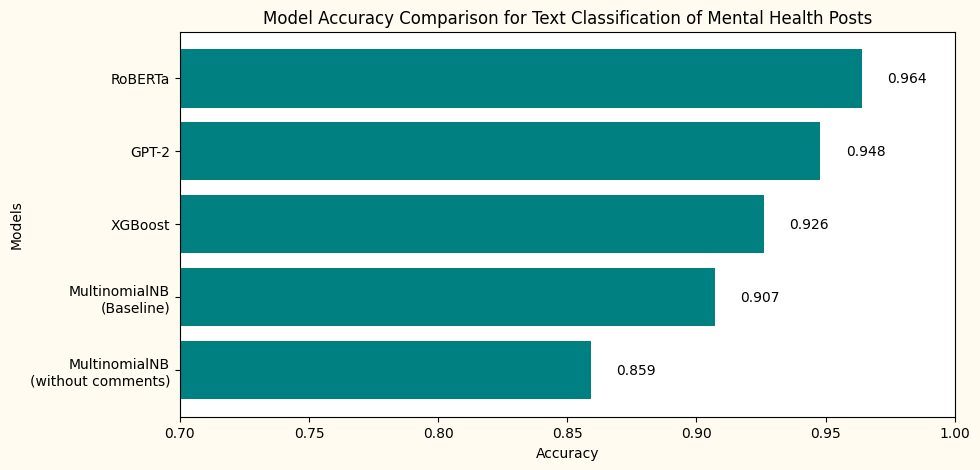

In [55]:
sorted_dict = sorted(scores_dict.items(), key=lambda item: item[1])
sorted_dict = {model: accuracy for model, accuracy in sorted_dict}

model_names = list(sorted_dict.keys())
accuracies = list(sorted_dict.values())

plt.figure(figsize=(10,5), facecolor='#fffbf0')
ax = plt.barh(model_names, accuracies, color='teal')
plt.title('Model Accuracy Comparison for Text Classification of Mental Health Posts')
plt.ylabel('Models')
plt.xlabel('Accuracy')

for bar, accuracy in zip(ax, accuracies):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{accuracy:.3f}', ha='left', va='center')

plt.xlim(0.7, 1)

plt.show()

From the table above, we can see that the RoBERTa model performs exceptionally well over the other models. Since it was designed specifically for NLP use-cases, it was expected that the model will perform better than others such as XGBoost and MultinomialNB. While we would recommend the transformer models for their performance and accuracy, both the RoBERTa and GPT-2 models are very resource intensive and typically requires a lot of computational power to run the models. Comparing them with XGBoost, which is about 3.8% less accurate but only takes seconds to run, it might be a wiser decision to deploy the XGBoost model instead, if resources are a hard constraint.

That being said, as the use-case of these models are to identify students' posts which possibly suggests mental-health related issues, we will still recommend the deployment of the RoBERTa model for its higher accuracy. This will help the school committee to identify and provide early intervention to students who might be facing mental-health issues at school more accurately and timely.

Albeit so, much more can be done to build a more accurate and robust model for the use case. Future improvements that can be considered include:

1. Getting more datapoints (Only about 2000 datapoints with a 50:50 class ratio was used)
2. Tuning the hyperparameters of the different models
3. Trying an ensemble of gradient boosted models together with XGBoost such as LightGBM
4. Trying out different combinations of models, stemmer, lemmatizer and vectorizers
5. Periodically updating and retraining the model with new datasets for the model to learn new and upcoming mental disorders